In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
#下載信用卡欺詐數據集
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

#V1~V28：為PCA後的主要參數
#Time：每一個交易間的秒數
#Amount：為交易金額
#Class：1為詐欺，0為無

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#確認不平衡狀況
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

#僅0.17%有詐欺的數據

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [ ]:
#資料前處理

cleaned_df = raw_df.copy()

#去除Time欄位
cleaned_df.pop('Time')

#Amount數值過大，做資料轉換
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [ ]:
#資料切割
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#將labels資料轉換
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
#資料正規化
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('訓練的標籤shape:', train_labels.shape)
print('驗證的標籤shape:', val_labels.shape)
print('測試的標籤shape:', test_labels.shape)

print('訓練的特徵shape:', train_features.shape)
print('驗證的特徵shape:', val_features.shape)
print('測試的特徵shape:', test_features.shape)

訓練的標籤shape: (182276,)
驗證的標籤shape: (45569,)
測試的標籤shape: (56962,)
訓練的特徵shape: (182276, 29)
驗證的標籤shape: (45569, 29)
測試的標籤shape: (56962, 29)


In [ ]:
~bool_train_labels

array([ True,  True,  True, ...,  True,  True,  True])

#了解數據分佈

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


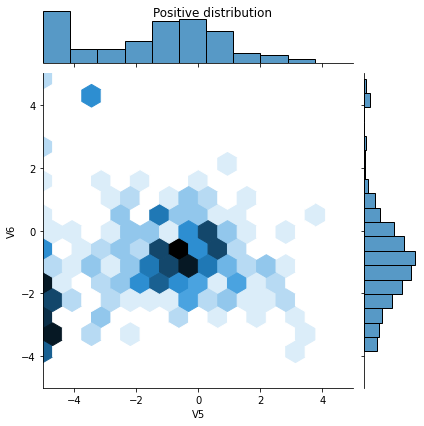

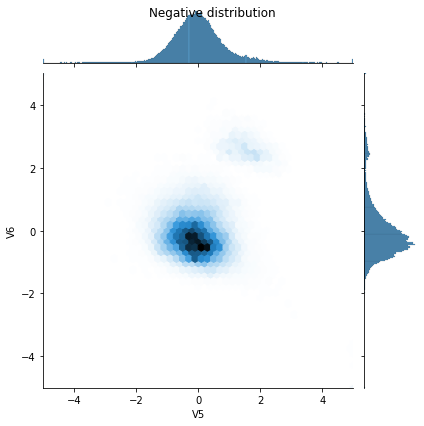

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns) #取得詐欺的相關資料
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns) #取得無詐欺的相關資料

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

#定義模型與衡量標準

In [ ]:
#希望訓練產生的衡量標準
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]
#建立模型要訓練的層內容
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

#建立模型

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

#建立提早結束的條件
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()

In [ ]:
model.predict(train_features[:10])

array([[0.3353988 ],
       [0.46835446],
       [0.52055   ],
       [0.35328692],
       [0.3057885 ],
       [0.66731745],
       [0.61434793],
       [0.3959231 ],
       [0.5453403 ],
       [0.6300975 ]], dtype=float32)

#設定正確的初始偏差

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6064


In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00047526],
       [0.00107267],
       [0.00319538],
       [0.0004206 ],
       [0.00159752],
       [0.00069302],
       [0.00050235],
       [0.00020686],
       [0.00021139],
       [0.0010117 ]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0124


In [ ]:
#確認初始權重
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0]) #權重從0開始
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

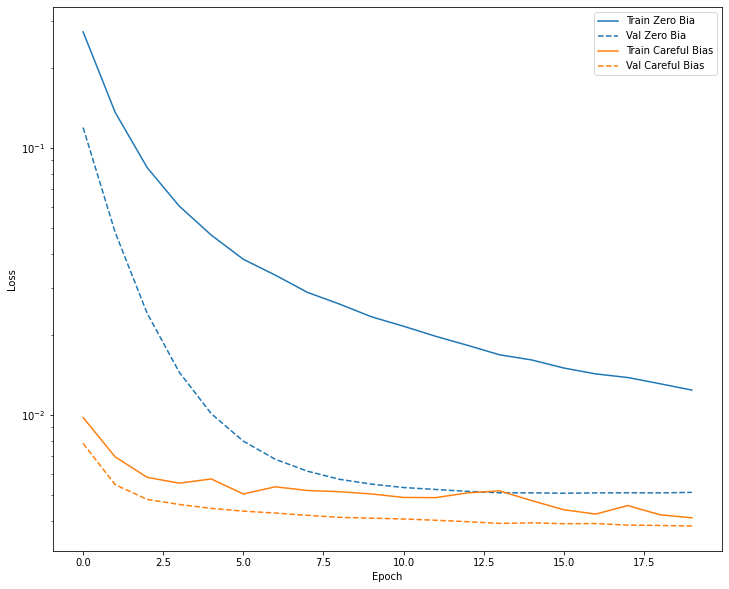

In [ ]:
plot_loss(zero_bias_history, "Zero Bia", 0) #0偏移量
plot_loss(careful_bias_history, "Careful Bias", 1) #些微偏移量
plt.legend()

#訓練模型

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 3s 19ms/step - loss: 0.0107 - tp: 66.8132 - fp: 10.8681 - tn: 139454.2418 - fn: 177.6484 - accuracy: 0.9987 - precision: 0.8613 - recall: 0.3189 - auc: 0.7880 - val_loss: 0.0081 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45482.0000 - val_fn: 87.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8847
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0084 - tp: 32.1868 - fp: 5.2637 - tn: 93971.7363 - fn: 131.3846 - accuracy: 0.9984 - precision: 0.8826 - recall: 0.1875 - auc: 0.8098 - val_loss: 0.0062 - val_tp: 19.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 68.0000 - val_accuracy: 0.9984 - val_precision: 0.7600 - val_recall: 0.2184 - val_auc: 0.9191
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0061 - tp: 50.3846 - fp: 8.3626 - tn: 93977.3846 - fn: 104.4396 - accuracy: 0.9988 - precision: 0.8465 - recall: 0.3045 - auc: 0.

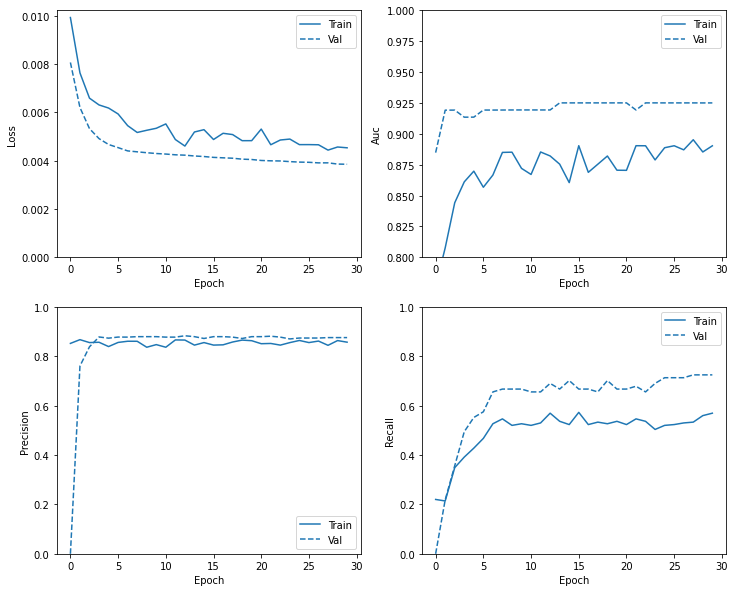

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(baseline_history)

#透過衡量指標觀察變化

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('合法的交易 (True Negatives): ', cm[0][0])
  print('誤判的詐欺交易 (False Positives): ', cm[0][1]) #錯過詐欺交易
  print('遺漏的詐欺交易 (False Negatives): ', cm[1][0]) #增加財務成本
  print('檢測到詐欺交易 (True Positives): ', cm[1][1])
  print('總詐欺交易: ', np.sum(cm[1]))

loss :  0.0037462604232132435
tp :  66.0
fp :  12.0
tn :  56849.0
fn :  35.0
accuracy :  0.9991748929023743
precision :  0.8461538553237915
recall :  0.6534653306007385
auc :  0.9303390383720398

合法的交易 (True Negatives):  56849
誤判的詐欺交易 (False Positives):  12
遺漏的詐欺交易 (False Negatives):  35
檢測到詐欺交易 (True Positives):  66
總詐欺交易:  101


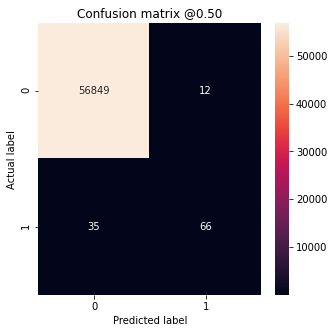

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [ ]:
#ROC

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

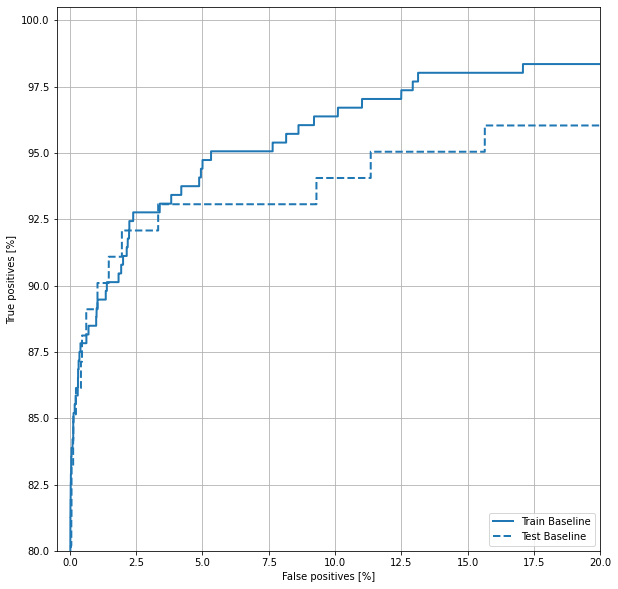

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#透過參數設定，讓神經網路能更多關注有問題的案件上

In [ ]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [ ]:
#添加class_weight，增加關注度
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 3s 19ms/step - loss: 2.6665 - tp: 72.2637 - fp: 13.8901 - tn: 150832.4505 - fn: 183.9670 - accuracy: 0.9987 - precision: 0.8398 - recall: 0.3184 - auc: 0.8090 - val_loss: 0.0074 - val_tp: 8.0000 - val_fp: 4.0000 - val_tn: 45478.0000 - val_fn: 79.0000 - val_accuracy: 0.9982 - val_precision: 0.6667 - val_recall: 0.0920 - val_auc: 0.9070
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 1.7451 - tp: 43.3297 - fp: 12.9451 - tn: 93971.6923 - fn: 112.6044 - accuracy: 0.9986 - precision: 0.7261 - recall: 0.2393 - auc: 0.8136 - val_loss: 0.0056 - val_tp: 47.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 40.0000 - val_accuracy: 0.9990 - val_precision: 0.8868 - val_recall: 0.5402 - val_auc: 0.9455
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.9654 - tp: 75.0879 - fp: 60.0549 - tn: 93925.3956 - fn: 80.0330 - accuracy: 0.9986 - precision: 0.5607 - recall: 0.4762 - auc: 0.8866 - val_loss

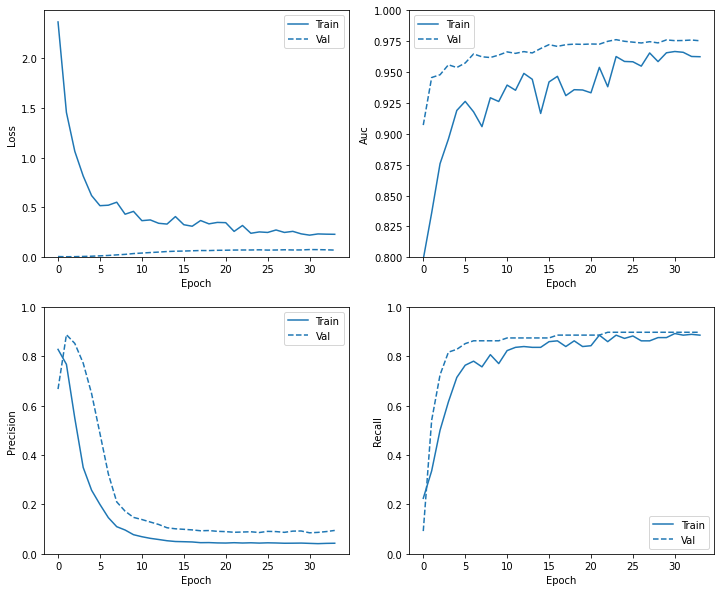

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07255149632692337
tp :  90.0
fp :  984.0
tn :  55877.0
fn :  11.0
accuracy :  0.9825322031974792
precision :  0.08379888534545898
recall :  0.8910890817642212
auc :  0.9889763593673706

合法的交易 (True Negatives):  55877
誤判的詐欺交易 (False Positives):  984
遺漏的詐欺交易 (False Negatives):  11
檢測到詐欺交易 (True Positives):  90
總詐欺交易:  101


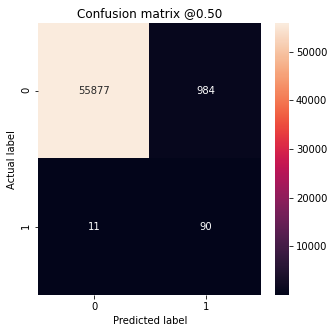

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

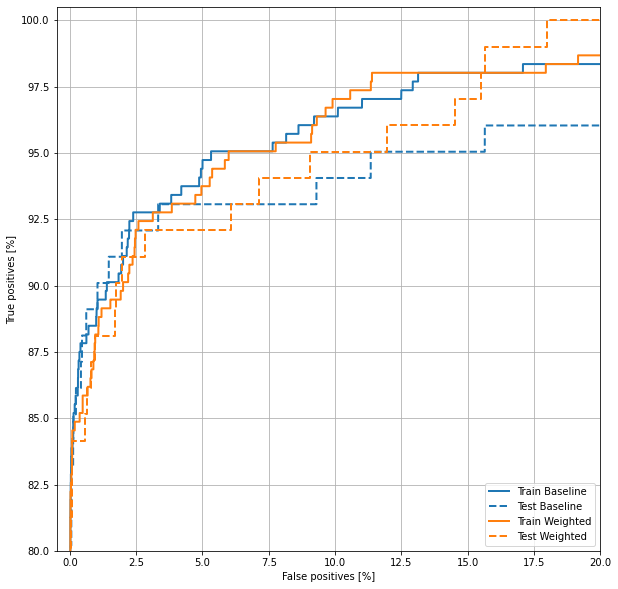

In [ ]:
#ROC

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')